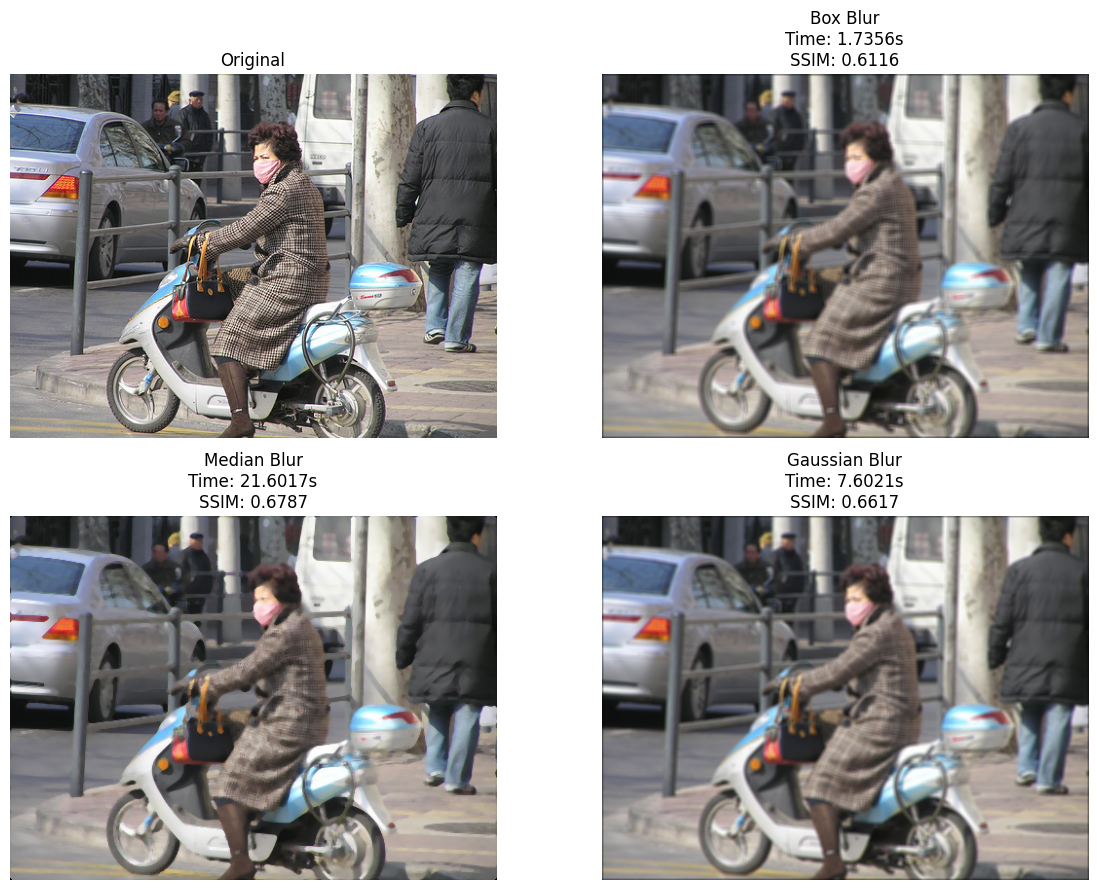

Times and SSIM:
Box Blur: 1.7356s, SSIM=0.6116
Median Blur: 21.6017s, SSIM=0.6787
Gaussian Blur: 7.6021s, SSIM=0.6617


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim

#Box blur
def box_blur_rgb_integral(image, kernel_size=3):
    h, w, c = image.shape
    pad = kernel_size // 2
    padded = np.pad(image, ((pad,pad),(pad,pad),(0,0)), mode='constant', constant_values=0)

    # Create integral image with extra row and column
    integral = np.zeros((padded.shape[0]+1, padded.shape[1]+1, c))
    integral[1:, 1:, :] = padded.cumsum(axis=0).cumsum(axis=1)

    output = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            y1, x1 = i, j
            y2, x2 = i + kernel_size - 1, j + kernel_size - 1  # inclusive window
            total = integral[y2+1, x2+1] - integral[y1, x2+1] - integral[y2+1, x1] + integral[y1, x1]
            output[i,j] = total / (kernel_size**2)
    return output


#Median blurring
def median_blur_rgb(image, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(image, ((pad,pad),(pad,pad),(0,0)), mode='constant', constant_values=0)
    h, w, c = image.shape
    output = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            for ch in range(c):
                region = padded[i:i+kernel_size, j:j+kernel_size, ch]
                output[i,j,ch] = np.median(region)
    return output

#Gaussian blurring for 1 dimension
def gaussian_kernel_1d(size, sigma):
    pad = size // 2
    x = np.arange(-pad, pad+1)
    kernel = np.exp(-x**2/(2*sigma**2))
    kernel /= kernel.sum()
    return kernel

def gaussian_blur_rgb_separable(image, kernel_size=5, sigma=1.0):
    h, w, c = image.shape
    kernel = gaussian_kernel_1d(kernel_size, sigma)
    pad = kernel_size // 2
    padded = np.pad(image, ((pad,pad),(pad,pad),(0,0)), mode='constant', constant_values=0)

    # Horizontal pass
    temp = np.zeros_like(padded)
    for i in range(h + 2*pad):
        for j in range(w):
            for ch in range(c):
                temp[i, j+pad, ch] = np.sum(padded[i, j:j+kernel_size, ch] * kernel)

    # Vertical pass
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            for ch in range(c):
                output[i,j,ch] = np.sum(temp[i:i+kernel_size, j+pad, ch] * kernel)
    return output

#Compute ssim for blurring evaluation
def compute_ssim(img1, img2):
    if img1.max() > 1.0:
        img1 = img1 / 255.0
    if img2.max() > 1.0:
        img2 = img2 / 255.0
    if img1.ndim == 3 and img1.shape[2] == 3:
        return ssim(img1, img2, data_range=1.0, channel_axis=-1)
    else:
        return ssim(img1, img2, data_range=1.0)

def main():
    image = plt.imread("2008_000014.jpg").astype(np.float64)

    # Box blur
    start = time.perf_counter()
    box = box_blur_rgb_integral(image, 5)
    t_box = time.perf_counter() - start
    ssim_box = compute_ssim(image, box)

    # Median blur
    start = time.perf_counter()
    median = median_blur_rgb(image, 5)
    t_median = time.perf_counter() - start
    ssim_median = compute_ssim(image, median)

    # Gaussian blur
    start = time.perf_counter()
    gaussian = gaussian_blur_rgb_separable(image, 5, 2.0)
    t_gaussian = time.perf_counter() - start
    ssim_gaussian = compute_ssim(image, gaussian)

    # Normalization
    image_disp = image / image.max()
    box_disp = box / box.max()
    median_disp = median / median.max()
    gaussian_disp = gaussian / gaussian.max()

    plt.figure(figsize=(12,9))
    plt.subplot(2,2,1)
    plt.title("Original")
    plt.imshow(image_disp); plt.axis("off")

    plt.subplot(2,2,2)
    plt.title(f"Box Blur\nTime: {t_box:.4f}s\nSSIM: {ssim_box:.4f}")
    plt.imshow(box_disp); plt.axis("off")

    plt.subplot(2,2,3)
    plt.title(f"Median Blur\nTime: {t_median:.4f}s\nSSIM: {ssim_median:.4f}")
    plt.imshow(median_disp); plt.axis("off")

    plt.subplot(2,2,4)
    plt.title(f"Gaussian Blur\nTime: {t_gaussian:.4f}s\nSSIM: {ssim_gaussian:.4f}")
    plt.imshow(gaussian_disp); plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Times and SSIM:")
    print(f"Box Blur: {t_box:.4f}s, SSIM={ssim_box:.4f}")
    print(f"Median Blur: {t_median:.4f}s, SSIM={ssim_median:.4f}")
    print(f"Gaussian Blur: {t_gaussian:.4f}s, SSIM={ssim_gaussian:.4f}")

if __name__ == "__main__":
    main()
